In [1]:
!pip install -q tqdm observations
!git clone -b experimental https://git@github.com/wenkesj/alchemy.git ~/alchemy
!(cd ~/alchemy; pip install -q .)

Cloning into '/content/alchemy'...
remote: Counting objects: 301, done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 301 (delta 159), reused 238 (delta 96), pack-reused 0
Receiving objects: 100% (301/301), 133.58 KiB | 8.35 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [0]:
from observations import mnist

(x_train, y_train), (x_test, y_test) = mnist('data')
train_size, test_size = len(x_train), len(x_test)

# Shared Model Body for comparison

In [0]:
import alchemy as ay
import tensorflow as tf

def model_fn(inputs_ph):
  return tf.cast(inputs_ph, tf.float32) / 127
#   inputs = tf.reshape(inputs_ph, [tf.shape(inputs_ph)[0], 28, 28, 1])
#   y = tf.layers.conv2d(tf.cast(inputs, tf.float32) / 127, 32, (3, 3), 
#                        activation=tf.nn.relu)
#   y = tf.layers.conv2d(y, 64, (3, 3), activation=tf.nn.relu)
#   y = tf.contrib.layers.flatten(y)
#   return y

In [0]:
import numpy as np
import sys
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
from tqdm import trange

epochs = 3
batch_size = 32
learning_rate = 6.25e-4


def train_fn(model):
  tf.reset_default_graph()
  tf.set_random_seed(42)
  np.random.seed(42)

  tf.reset_default_graph()
  
  inputs_ph = tf.placeholder(tf.uint8, (None, 784), name='inputs')
  labels_ph = tf.placeholder(tf.int32, (None,), name='labels')
  is_training = tf.placeholder(tf.bool, [], name='training')

  logits = model_fn(inputs_ph)
  logits = model(logits, is_training)

  pred_op = tf.argmax(logits, axis=-1, output_type=tf.int32)
  accy_op = tf.reduce_mean(
      tf.cast(tf.equal(pred_op, labels_ph), tf.float32), axis=-1)
  loss_op = tf.reduce_mean(
      tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=labels_ph, logits=logits, name='loss'),
      axis=-1)
  train_op = tf.train.AdamOptimizer(
      learning_rate=learning_rate).minimize(loss_op)

  with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    accuracies = []
    for epoch in range(epochs):
      train_loss = 0.
      train_set = ay.utils.generate_dataset((x_train, y_train), batch_size)
      train_msg = 'Epoch {} mean train loss = {:.4f}'
      train_range = trange(
          train_size // batch_size, 
          desc=train_msg.format(epoch, train_loss),
          file=sys.stdout)
      for _ in train_range:
        x, y = next(train_set)
        train_loss, _ = sess.run((loss_op, train_op), feed_dict={
            inputs_ph: x,
            labels_ph: y,
            is_training: True,
        })
        train_range.set_description(train_msg.format(epoch, train_loss))

      test_accy = 0.
      test_set = ay.utils.generate_dataset((x_test, y_test), batch_size)
      for test_steps_taken in range(test_size // batch_size):
        x, y = next(test_set)
        test_accy_ = sess.run(accy_op, feed_dict={
            inputs_ph: x,
            labels_ph: y,
            is_training: False,
        })
        test_accy += test_accy_
      accy = 100. * (test_accy / (test_steps_taken + 1))
      accuracies.append(accy)
      print('Epoch {} accy {:.2f}%'.format(epoch, accy))
    return accuracies

# Compare the 2 implementations (Dense vs. Dense + WTA)

In [0]:
def dense(logits, is_training):
  logits = tf.layers.dense(logits, units=128, activation=tf.nn.relu)
  return tf.layers.dense(logits, units=10)

def dense_d_wta(logits, is_training):
  logits = tf.layers.dense(logits, units=128, activation=tf.nn.crelu)
  logits = ay.contrib.layers.DWTA()(logits, training=is_training)
  logits = tf.layers.dense(logits, units=10)
  return logits

models = [
    dense,
    dense_d_wta]

Epoch 0 mean train loss = 0.0505: 100%|██████████| 1875/1875 [00:11<00:00, 165.66it/s]


Epoch 0 accy 94.99%
Epoch 1 mean train loss = 0.0469:  48%|████▊     | 898/1875 [00:05<00:05, 164.78it/s]

Epoch 1 mean train loss = 0.0576: 100%|██████████| 1875/1875 [00:11<00:00, 165.15it/s]
Epoch 1 accy 95.99%
Epoch 2 mean train loss = 0.0601:   3%|▎         | 48/1875 [00:00<00:13, 134.87it/s]

Epoch 2 mean train loss = 0.0474: 100%|██████████| 1875/1875 [00:11<00:00, 169.76it/s]


Epoch 2 accy 96.54%
Epoch 0 mean train loss = 0.1849:  42%|████▏     | 787/1875 [00:21<00:30, 35.90it/s]

Epoch 0 mean train loss = 0.0244: 100%|██████████| 1875/1875 [00:52<00:00, 35.85it/s]


Epoch 0 accy 95.29%
Epoch 1 mean train loss = 0.0695:  42%|████▏     | 785/1875 [00:21<00:29, 36.35it/s]

Epoch 1 mean train loss = 0.0523: 100%|██████████| 1875/1875 [00:51<00:00, 36.27it/s]


Epoch 1 accy 95.73%
Epoch 2 mean train loss = 0.0372:  42%|████▏     | 783/1875 [00:21<00:30, 35.89it/s]

Epoch 2 mean train loss = 0.0191: 100%|██████████| 1875/1875 [00:52<00:00, 35.50it/s]


Epoch 2 accy 97.08%


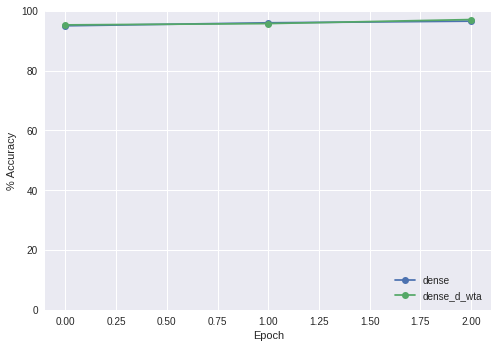

In [6]:
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0

fig, ax = plt.subplots()
ax.set_ylabel('% Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim([0, 100.])
for name, accuracies in [(model.__name__, train_fn(model)) 
                         for model in models]:
  ax.plot(accuracies, marker='o', label=name)
_ = ax.legend(loc='lower right', shadow=True)